In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [54]:
img = cv2.imread(os.path.expanduser('~/Desktop/t.png'))
img = cv2.resize(img, (1920, 2592)) # multiple of 32
img.shape

(2592, 1920, 3)

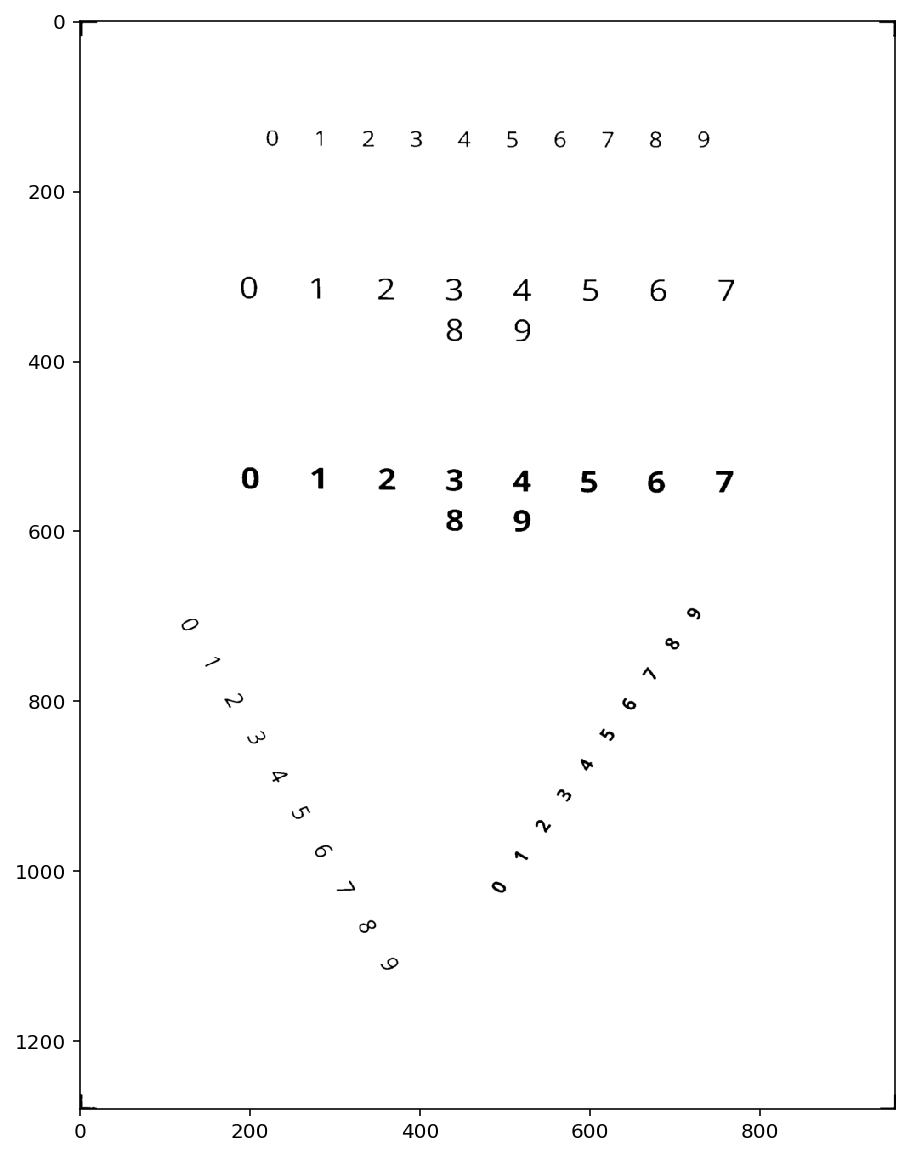

In [47]:
plt.figure(figsize=(20, 10)); plt.imshow(img)

In [27]:
def decode_predictions(scores, geometry, min_confidence):
    """ source: https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/ """
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    """ source: https://github.com/jrosebr1/imutils """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [49]:
out_layers = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]
net = cv2.dnn.readNet('/Users/Johannes/Studium/Master/SS-19/Projektseminar-Regelungstechnik/models/EAST/frozen_east_text_detection.pb')

In [50]:
W, H, _ = img.shape
blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(out_layers)

(rects, confidences) = decode_predictions(scores, geometry, 0.01)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [51]:
res_img = img.copy()
for (startX, startY, endX, endY) in boxes:
    startX = int(startX)
    startY = int(startY)
    endX = int(endX)
    endY = int(endY)
    cv2.rectangle(res_img, (startX, startY), (endX, endY), (0, 255, 0), 2)

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x11a293668>)

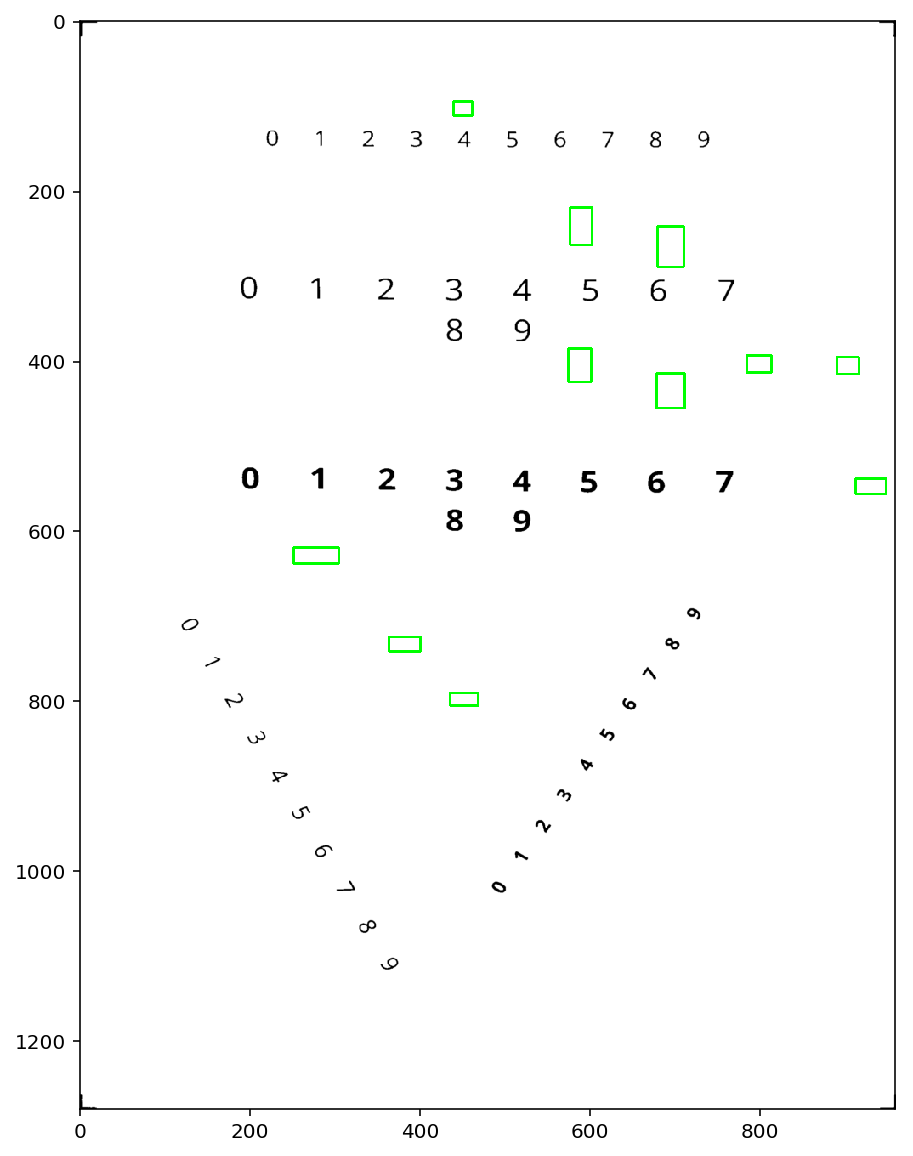

In [52]:
plt.figure(figsize=(20, 10)), plt.imshow(res_img)